In [1]:
# importing lib and setting a list of meshes to be tested
import sys 
import amfe
import os
import matplotlib.pyplot as plt
import numpy as np
from scipy.sparse import linalg as splinalg
import copy
%matplotlib notebook


# making the path relative to the project
local_folder = os.getcwd()[:]
os.chdir('..')
project_folder = os.getcwd()[:]
os.chdir(local_folder)
sys.path.append(r'project_folder')

mesh_inp = os.path.join(project_folder,r'data\ansys_simple_blade_disc_files\simple_blade_disc.inp')


m = amfe.Mesh()
m.import_inp(mesh_inp,1.0)

m.split_in_groups()

print(m.groups.keys())



Python was not able to load the fast fortran assembly routines.

Python was not able to load the fast fortran material routines.

Warning! Using mpiexec in global path
Warning! Using python in global path
*************************************************************

Loading Abaqus-mesh from D:\NDCIS\framework\data\ansys_simple_blade_disc_files\simple_blade_disc.inp
Can not read the given string list
WARNING 3D case were selected
Mesh D:\NDCIS\framework\data\ansys_simple_blade_disc_files\simple_blade_disc.inp successfully imported. 
Assign a material to a physical group.
*************************************************************
dict_keys(['SOLID_1_1_SOLID_ELSET', 'LOW_ELSET', 'HIGH_ELSET', 'DIRICHLET_ELSET', 'TOP_LOW_ELSET', 'TOP_HIGH_ELSET', 'TOP_ELSET', 'SOLID_1_1_ELSET'])


<IPython.core.display.Javascript object>


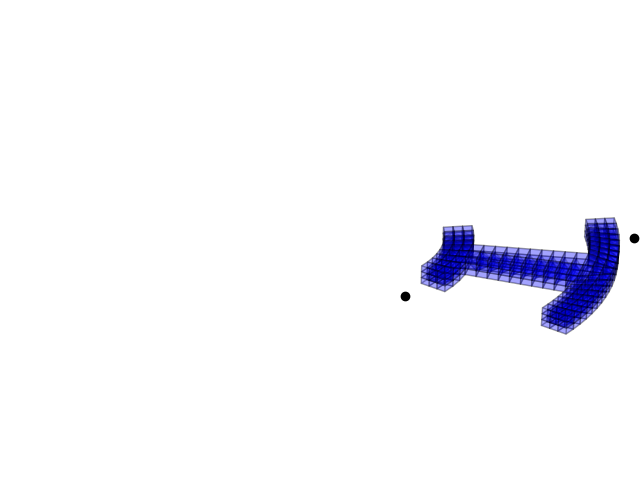

Element in mesh is not supported.
Element in mesh is not supported.
Element in mesh is not supported.
Element in mesh is not supported.
Element in mesh is not supported.
Element in mesh is not supported.
Element in mesh is not supported.


(-21.047588429999998,
 21.047588429999998,
 -21.047588429999998,
 21.047588429999998)

In [2]:
sub_domain = m.groups['SOLID_1_1_SOLID_ELSET']


ax = amfe.plot3Dmesh(m, ax=None, boundaries=True, alpha=0.2, color='blue', scale = 1000, plot_nodes=False)
ax.view_init(-90, 0)
#ax.set_aspect('equal', adjustable='box')
xlim = ax.get_xlim()
ax.set_ylim(xlim)
ax.set_zlim(xlim)
plt.axis('off')

In [3]:
my_comp = amfe.CraigBamptonComponent()
my_comp.set_mesh_obj(m)

my_material = amfe.KirchhoffMaterial(E=210E9, nu=0.3, rho=7.86E3, plane_stress=True, thickness=1.0)
my_comp.set_domain('SOLID_1_1_SOLID_ELSET',my_material)

K, f = my_comp.assembly_class.assemble_k_and_f()
K_, f = my_comp.assembly_class.assemble_k_and_f_neumann()
M = my_comp.assembly_class.assemble_m()

dirsub = m.get_submesh('phys_group', 'DIRICHLET_ELSET')
cyclic_low = m.get_submesh('phys_group', 'LOW_ELSET')
cyclic_high = m.get_submesh('phys_group', 'HIGH_ELSET')
cyclic_top_low = m.get_submesh('phys_group', 'TOP_LOW_ELSET')
cyclic_top_high = m.get_submesh('phys_group', 'TOP_HIGH_ELSET')

id_matrix = my_comp.assembly_class.id_matrix
dir_dofs = amfe.get_dirichlet_dofs(dirsub, direction ='xyz', id_matrix=id_matrix)
low_dofs = amfe.get_dirichlet_dofs(cyclic_low, direction ='xyz', id_matrix=id_matrix)
high_dofs = amfe.get_dirichlet_dofs(cyclic_high, direction ='xyz', id_matrix=id_matrix)
top_low_dofs = amfe.get_dirichlet_dofs(cyclic_top_low, direction ='xyz', id_matrix=id_matrix)
top_high_dofs = amfe.get_dirichlet_dofs(cyclic_top_high, direction ='xyz', id_matrix=id_matrix)


# concatenating cyclic dofs
all_low_dofs =[]
all_low_dofs.extend(low_dofs)
all_low_dofs.extend(top_low_dofs)
all_high_dofs = []
all_high_dofs.extend(high_dofs)
all_high_dofs.extend(top_high_dofs)


# remove Dirichle dofs at cyclic dofs 
dir_dofs = list(set(dir_dofs).difference(all_low_dofs))
dir_dofs = list(set(dir_dofs).difference(all_high_dofs))

Preallocating the stiffness matrix
Done preallocating stiffness matrix with 303 elements and 1716 dofs.
Time taken for preallocation: 0.03 seconds.


In [4]:
K, M, f = my_comp.insert_dirichlet_boundary_cond(K,M,f,dir_dofs)
K_mod, M_mod, f_mod = my_comp.insert_cyclic_symm_boundary_cond(K, M, f, low_dofs = all_low_dofs , high_dofs = all_high_dofs , theta = 0.0)    
Kii, S, S_inv, T, fi = my_comp.create_selection_operator(dir_dofs, K_mod, f_mod, remove = True)
Mii, Sm, Sm_inv, Tm = my_comp.create_selection_operator(dir_dofs, M_mod, remove = True)
print('Size of the original system is %i' %len(f))
print('Size of the reduced system is %i' %len(fi))

C:\Users\ndcsi\.conda\envs\ndcsi\lib\site-packages\scipy\sparse\compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)
C:\Users\ndcsi\.conda\envs\ndcsi\lib\site-packages\scipy\sparse\compressed.py:774: SparseEfficiencyWarning: Changing the sparsity structure of a csc_matrix is expensive. lil_matrix is more efficient.
  SparseEfficiencyWarning)


The K, M and f are ordered according its original dofs order
returning reduced right side, please umpack 5 elementes
Size of the original system is 1716
Size of the reduced system is 1620


In [5]:
num_of_modes = 6
omega, V_dynamic = splinalg.eigs(Kii, k=num_of_modes, M = Mii, which='SM')

V_dynamic = np.real(V_dynamic)
# baking to Augmented System
aug_mode_shapes = []
for i in range(num_of_modes):
    u_global = T(V_dynamic [:,i])
    u_dir = u_global[dir_dofs]
    if abs(u_dir).max()>0.0:
        raise('Error going back to Augmented system')
    aug_mode_shapes.append(u_global)

aug_mode_shapes = np.array(aug_mode_shapes)

In [6]:
# seeting some important path
local_folder= copy.copy(os.getcwd()) 
os.chdir('..')
project_folder = copy.copy(os.getcwd())   # getting project path
os.chdir(local_folder)
sys.path.append(project_folder)

from wrappers.ansys_apdl_wrapper import pyAPDL

result_folder = os.path.join(project_folder, r'data\ansys_simple_blade_disc_files')

my_ansys = pyAPDL(result_folder = result_folder)


num_harmonics = 4
num_modes = 6
my_ansys.var_dict['number_of_harmonics']  = num_harmonics 
my_ansys .var_dict['number_of_modes']  = num_modes  
my_ansys.read_frequencies(filename_prefix='Frequency_harm_',ext='.txt')

freq_dict = my_ansys.freq_dict
modes_dict = my_ansys.read_mode_shapes()

<IPython.core.display.Javascript object>


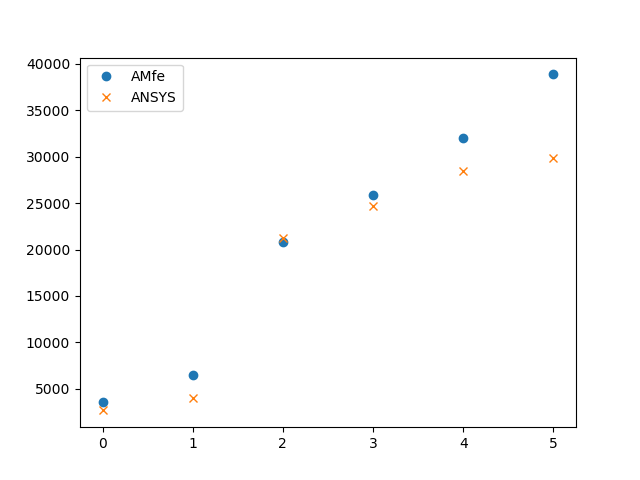

In [18]:
fig = plt.figure()
plt.plot(np.arange(len(omega)),np.sort(np.real(np.sqrt(omega)/(2.0*np.pi))),'o', label = 'AMfe')
plt.plot(np.arange(len(omega)),freq_dict[1],'x', label = 'ANSYS')
plt.legend()


In [8]:
np.sort(aug_mode_shapes[0])

array([ -1.73684675,  -1.7340791 ,  -1.72801423, ...,  10.80854087,
        10.80857691,  10.81342186])

In [9]:
np.pi

3.141592653589793